Cette baseline vise à tester la capacité d’un classifieur simple à reconnaître les classes du dataset NCT-CRC-HE-100K à partir de formes synthétiques issues de SSM.
L’objectif est méthodologique : évaluer la séparabilité inter-classe à partir de représentations morphologiques simplifiées<br>
Schéma: pipeline SSM → features → métriques FID/LPIPS, classifieur downstream

In [1]:
# ==========================================================
# 📘 Baseline morphologique – Statistical Shape Model (SSM)
# ==========================================================

# --- Imports système et chemins ---
from pathlib import Path
import os

# --- Détection du projet (exécution depuis notebooks/) ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "04_baseline_ssm"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "04_baseline_ssm"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "04_baseline_ssm"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "04_baseline_ssm"
DATA_ROOT       = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR      = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

# Création des dossiers
for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- Dossiers spécifiques à cette baseline ---
# Masques binaires : dans OUTPUTS_DIR pour cette baseline
MASKS_DIR = OUTPUTS_DIR / "masks_sitk"
MASKS_DIR.mkdir(parents=True, exist_ok=True)

# Features et artifacts : dans ARTIFACTS_DIR
FEATURES_DIR = ARTIFACTS_DIR / "04_baseline_ssm"
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

# Modèles PCA : dans MODELS_DIR
SSM_MODELS_DIR = MODELS_DIR / "04_baseline_ssm"
SSM_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# --- Contrôle ---
print(f"✅ PROJECT_ROOT    : {PROJECT_ROOT}")
print(f"✅ DATA_ROOT       : {DATA_ROOT}")
print(f"✅ CONFIG_DIR      : {CONFIG_DIR}")
print(f"✅ MODELS_DIR      : {MODELS_DIR}")
print(f"✅ ARTIFACTS_DIR   : {ARTIFACTS_DIR}")
print(f"✅ OUTPUTS_DIR     : {OUTPUTS_DIR}")
print(f"✅ MASKS_DIR       : {MASKS_DIR}")
print(f"✅ FEATURES_DIR    : {FEATURES_DIR}")
print(f"✅ SSM_MODELS_DIR  : {SSM_MODELS_DIR}")


✅ PROJECT_ROOT    : /workspace
✅ DATA_ROOT       : /workspace/data
✅ CONFIG_DIR      : /workspace/configs
✅ MODELS_DIR      : /workspace/models
✅ ARTIFACTS_DIR   : /workspace/artifacts
✅ OUTPUTS_DIR     : /workspace/outputs/04_baseline_ssm
✅ MASKS_DIR       : /workspace/outputs/04_baseline_ssm/masks_sitk
✅ FEATURES_DIR    : /workspace/artifacts/04_baseline_ssm
✅ SSM_MODELS_DIR  : /workspace/models/04_baseline_ssm


In [2]:
# ==========================================================
# 🧠 Imports scientifiques et configuration générale
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from tqdm import tqdm
import random
import SimpleITK as sitk
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.measure import regionprops, moments_hu
from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_ubyte

In [3]:
# --- Style d'affichage ---
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "image.cmap": "gray"
})

# --- Fixer la graine aléatoire pour reproductibilité ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# --- Vérification GPU pour compatibilité torch (optionnelle) ---
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except ImportError:
    device = "cpu"

print(f"✅ Environnement prêt — seed={SEED}, device={device}")

✅ Environnement prêt — seed=42, device=cuda


In [4]:
IMAGE_SIZE = 256
SAMPLES_PER_CLASS = 300
VAHADANE_ENABLE = True

# MASKS_DIR est déjà défini dans la cellule 1
# MASKS_DIR.mkdir(parents=True, exist_ok=True)  # Déjà créé dans la cellule 1

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device utilisé : {DEVICE}")

# --- Initialisation du dataset ---
# Utiliser DATAGENERATOR_PATH défini dans la cellule 1
import sys
if str(DATAGENERATOR_PATH) not in sys.path:
    sys.path.append(str(DATAGENERATOR_PATH))

from histo_dataset import HistoDataset

train_ds = HistoDataset(
    root_data=str(DATA_ROOT),
    split="train",
    output_size=IMAGE_SIZE,
    pixel_range="imagenet",
    balance_per_class=True,
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),
    vahadane_device=DEVICE,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS
)

✅ Device utilisé : cuda
🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (300 images / classe).


In [6]:
# ==========================================================
# 🧬 Génération contrôlée de masques binaires (HistoDataset + SimpleITK)
# ==========================================================

import SimpleITK as sitk
from tqdm import tqdm
import torch, csv, random
from pathlib import Path
import numpy as np

# --- Fonction de conversion tensor → masque binaire ---
def create_mask_from_tensor(x_tensor):
    """Convertit un tenseur RGB normalisé en image SimpleITK binaire (seuillage Otsu)."""
    img_np = (x_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_sitk = sitk.GetImageFromArray(img_np, isVector=True)
    gray = sitk.VectorIndexSelectionCast(img_sitk, 0)
    return sitk.OtsuThreshold(gray, 0, 1)

# --- Génération et sauvegarde par classe ---
for cls_name, cls_idx in train_ds.class_to_idx.items():
    out_dir = MASKS_DIR / cls_name
    out_dir.mkdir(parents=True, exist_ok=True)
    manifest_path = out_dir / "manifest.csv"

    class_indices = [i for i, (ci, _) in enumerate(train_ds._epoch_indices) if ci == cls_idx]
    random.shuffle(class_indices)
    class_indices = class_indices[:SAMPLES_PER_CLASS]

    rows = []
    for i in tqdm(class_indices, desc=f"Génération {cls_name}", leave=False):
        x, y, src_path = train_ds[i]
        src_stem = Path(src_path).stem
        mask = create_mask_from_tensor(x)

        mask_path = out_dir / f"{src_stem}__mask.tif"
        sitk.WriteImage(mask, str(mask_path))

        rows.append({"mask_path": str(mask_path), "source_path": str(src_path)})

    # --- Écriture du manifest CSV ---
    with open(manifest_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["mask_path", "source_path"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"✅ {len(rows)} masques + manifest : {manifest_path}")

print(f"\n✅ Tous les masques enregistrés dans : {MASKS_DIR}")


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/ADI/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/BACK/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/DEB/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/LYM/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/MUC/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/MUS/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/NORM/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/STR/manifest.csv


✅ 300 masques + manifest : /workspace/outputs/04_baseline_ssm/masks_sitk/TUM/manifest.csv

✅ Tous les masques enregistrés dans : /workspace/outputs/04_baseline_ssm/masks_sitk


In [7]:
# ==========================================================
# 📂 Lecture des manifests générés
# ==========================================================
import pandas as pd

mask_manifests = list(MASKS_DIR.glob("*/manifest.csv"))
assert mask_manifests, f"Aucun manifest trouvé dans {MASKS_DIR}"

records = []
for manifest_path in mask_manifests:
    cls_name = manifest_path.parent.name
    df = pd.read_csv(manifest_path)
    df["class"] = cls_name
    records.append(df)

df_masks = pd.concat(records, ignore_index=True)
print(f"✅ {len(df_masks)} masques détectés ({len(mask_manifests)} classes).")
display(df_masks.head())


✅ 2700 masques détectés (9 classes).


mask_path  \
0  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
1  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
2  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
3  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
4  /workspace/outputs/04_baseline_ssm/masks_sitk/...   

                                         source_path class  
0  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-QMANKP...   LYM  
1  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-DLVHPM...   LYM  
2  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-GQEFRV...   LYM  
3  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-WIKKPR...   LYM  
4  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-AMIQAK...   LYM

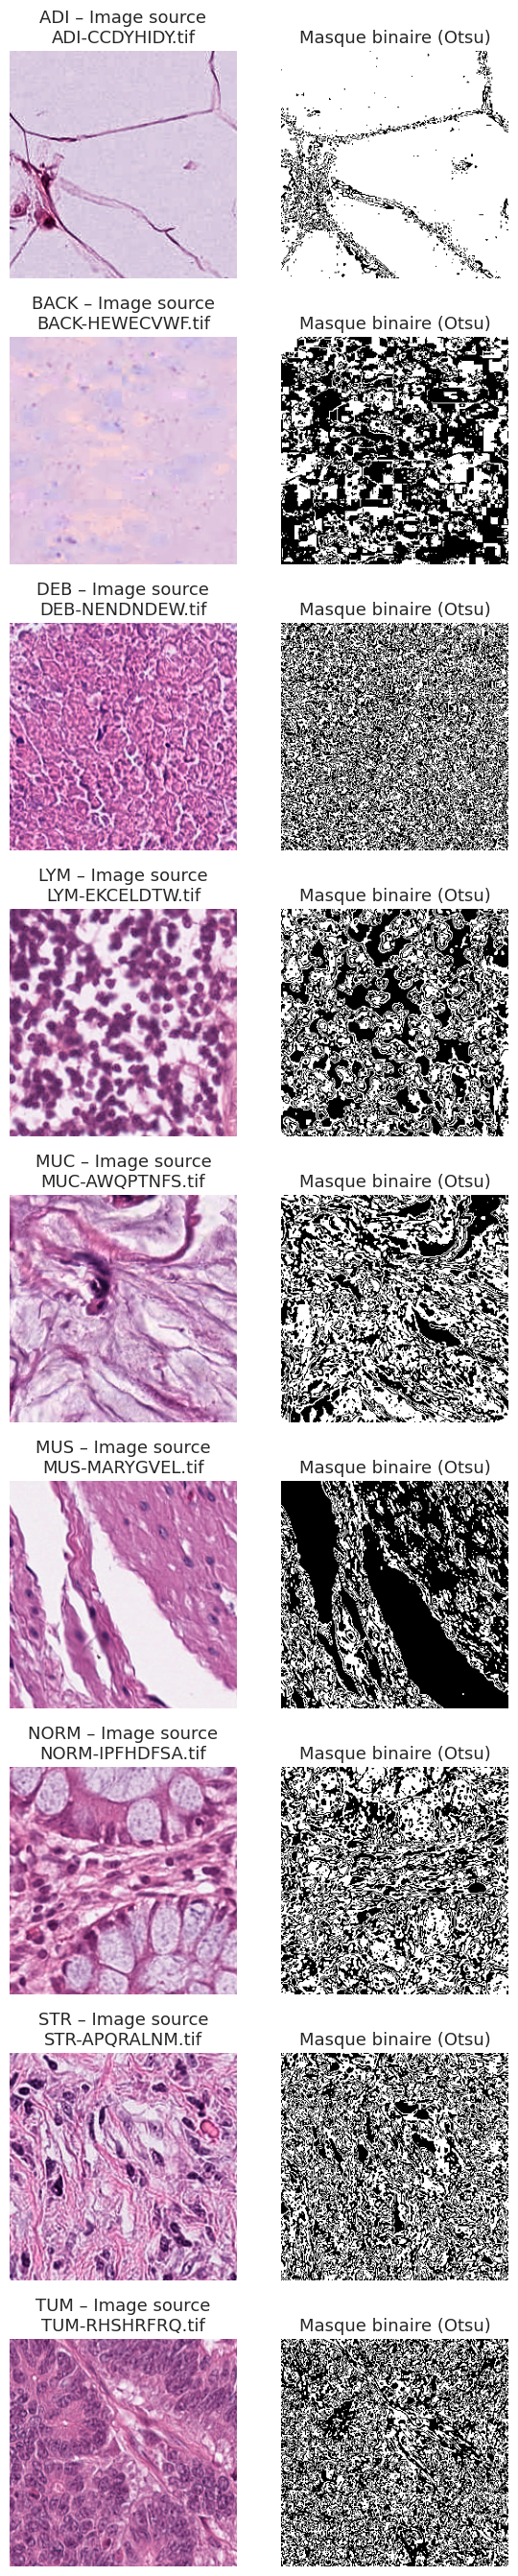

In [8]:
# ==========================================================
# 🔍 Contrôle visuel apparié via manifest (1 par classe)
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image
import numpy as np
import random

classes = list(train_ds.class_to_idx.keys())
pairs = []

for cls in classes:
    cls_dir = MASKS_DIR / cls
    manifest_path = cls_dir / "manifest.csv"
    if not manifest_path.exists():
        print(f"⚠️ Pas de manifest pour {cls}")
        continue
    dfm = pd.read_csv(manifest_path)
    if dfm.empty:
        print(f"⚠️ Manifest vide pour {cls}")
        continue
    row = dfm.sample(1, random_state=random.randint(0, 10_000)).iloc[0]
    pairs.append((cls, Path(row["mask_path"]), Path(row["source_path"])))

n = len(pairs)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n))
if n == 1:
    axes = np.array([axes])

for i, (cls, mask_path, src_path) in enumerate(pairs):
    # masque
    m = sitk.ReadImage(str(mask_path))
    m_np = sitk.GetArrayFromImage(m)

    # image source (affiche la version du disque telle quelle)
    img = Image.open(src_path).convert("RGB")
    img_np = np.asarray(img) / 255.0

    ax_img, ax_mask = axes[i]
    ax_img.imshow(img_np);   ax_img.set_title(f"{cls} – Image source\n{src_path.name}"); ax_img.axis("off")
    ax_mask.imshow(m_np, cmap="gray"); ax_mask.set_title("Masque binaire (Otsu)"); ax_mask.axis("off")

plt.tight_layout(); plt.show()


In [9]:
# ==========================================================
# 🔬 Analyse morphologique des masques binaires (SimpleITK)
# ==========================================================
import pandas as pd
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
from pathlib import Path

# --- Chargement des manifests existants ---
mask_manifests = list(MASKS_DIR.glob("*/manifest.csv"))
assert mask_manifests, f"Aucun manifest trouvé dans {MASKS_DIR}"

records = []
for manifest_path in mask_manifests:
    cls_name = manifest_path.parent.name
    df = pd.read_csv(manifest_path)
    df["class"] = cls_name
    records.append(df)

df_masks = pd.concat(records, ignore_index=True)
print(f"✅ {len(df_masks)} masques détectés ({len(mask_manifests)} classes).")


# --- Fonction d'analyse morphologique sur un masque binaire ---
def analyze_mask_sitk(mask_path: str):
    """
    Calcule des descripteurs morphologiques simples à partir d'un masque binaire.
    """
    try:
        mask = sitk.ReadImage(str(mask_path))
        mask = sitk.Cast(mask, sitk.sitkUInt8)

        # Composantes connectées
        cc = sitk.ConnectedComponent(mask)
        stats = sitk.LabelShapeStatisticsImageFilter()
        stats.Execute(cc)

        num_obj = stats.GetNumberOfLabels()
        if num_obj == 0:
            return {
                "num_objects": 0,
                "mean_area": 0,
                "mean_roundness": 0,
                "mean_perimeter": 0,
            }

        areas = [stats.GetPhysicalSize(l) for l in stats.GetLabels()]
        roundness = [stats.GetRoundness(l) for l in stats.GetLabels()]
        perimeters = [stats.GetPerimeter(l) for l in stats.GetLabels()]

        return {
            "num_objects": num_obj,
            "mean_area": float(np.mean(areas)),
            "mean_roundness": float(np.mean(roundness)),
            "mean_perimeter": float(np.mean(perimeters)),
        }

    except Exception as e:
        return {"num_objects": np.nan, "mean_area": np.nan, "mean_roundness": np.nan, "error": str(e)}


# --- Application sur tous les masques ---
results = []
for _, row in tqdm(df_masks.iterrows(), total=len(df_masks), desc="Analyse des masques"):
    metrics = analyze_mask_sitk(row["mask_path"])
    metrics.update({
        "mask_path": row["mask_path"],
        "source_path": row["source_path"],
        "class": row["class"],
    })
    results.append(metrics)

df_morpho_sitk = pd.DataFrame(results)

# --- Nettoyage et sauvegarde ---
df_morpho_sitk = df_morpho_sitk.dropna(subset=["num_objects"])
out_csv = FEATURES_DIR / "morpho_features_sitk.csv"
df_morpho_sitk.to_csv(out_csv, index=False)

print(f"✅ Analyse morphologique terminée ({len(df_morpho_sitk)} entrées).")
print(f"📄 Résultats sauvegardés : {out_csv}")
display(df_morpho_sitk.head())


✅ 2700 masques détectés (9 classes).


Analyse des masques: 100%|██████████| 2700/2700 [00:42<00:00, 63.84it/s]


✅ Analyse morphologique terminée (2700 entrées).
📄 Résultats sauvegardés : /workspace/artifacts/04_baseline_ssm/morpho_features_sitk.csv


num_objects  mean_area  mean_roundness  mean_perimeter  \
0         2261  16.077842        1.093535       15.950313   
1         2443  14.354892        1.037458       16.142349   
2         2158  16.867470        1.087852       16.798845   
3         2180  15.982111        1.090215       16.246547   
4         2183  15.963812        1.043177       16.838003   

                                           mask_path  \
0  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
1  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
2  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
3  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
4  /workspace/outputs/04_baseline_ssm/masks_sitk/...   

                                         source_path class  
0  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-QMANKP...   LYM  
1  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-DLVHPM...   LYM  
2  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-GQEFRV...   LYM  
3  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-WIKKPR...   LYM  
4  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-AMIQAK...   LYM

In [10]:
# ==========================================================
# 🧠 Enrichissement morphologique (scikit-image)
# ==========================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from skimage.io import imread
from skimage.measure import moments_hu


def extract_skimage_features(mask_path: str):
    """
    Calcule descripteurs avancés de forme et texture (Hu moments, GLCM, regionprops).
    Compatible avec scikit-image >= 0.22.
    """
    try:
        # Lecture du masque binaire
        mask_np = imread(mask_path)
        if mask_np.ndim == 3:
            mask_np = mask_np[..., 0]  # garder un seul canal si RGB accidentellement

        # Conversion stricte en binaire uint8
        mask_np = (mask_np > 0).astype(np.uint8)

        # --- Descripteurs de forme (regionprops) ---
        props = measure.regionprops(mask_np)
        if len(props) == 0:
            return {
                "mean_eccentricity": 0.0,
                "mean_solidity": 0.0,
                "mean_extent": 0.0,
                "mean_perimeter": 0.0,
                "hu_1": 0.0,
                "hu_2": 0.0,
                "glcm_contrast": 0.0,
                "glcm_homogeneity": 0.0,
                "glcm_energy": 0.0,
                "glcm_correlation": 0.0,
            }

        ecc = np.mean([p.eccentricity for p in props])
        solidity = np.mean([p.solidity for p in props])
        extent = np.mean([p.extent for p in props])
        perimeter = np.mean([p.perimeter for p in props])

        # --- Moments invariants de Hu ---
        hu = moments_hu(mask_np)
        hu_feats = {f"hu_{i+1}": float(v) for i, v in enumerate(hu)}

        # --- Texture GLCM (Gray-Level Co-Occurrence Matrix) ---
        gray_u8 = img_as_ubyte(mask_np)  # assure niveaux 0–255
        glcm = graycomatrix(
            gray_u8,
            distances=[1],
            angles=[0],
            levels=256,
            symmetric=True,
            normed=True
        )

        glcm_feats = {
            "glcm_contrast": float(graycoprops(glcm, "contrast")[0, 0]),
            "glcm_homogeneity": float(graycoprops(glcm, "homogeneity")[0, 0]),
            "glcm_energy": float(graycoprops(glcm, "energy")[0, 0]),
            "glcm_correlation": float(graycoprops(glcm, "correlation")[0, 0]),
        }

        return {
            "mean_eccentricity": ecc,
            "mean_solidity": solidity,
            "mean_extent": extent,
            "mean_perimeter": perimeter,
            **hu_feats,
            **glcm_feats,
        }

    except Exception as e:
        return {"error": str(e)}


# ==========================================================
# ⚙️ Application parallèle sur tous les masques
# ==========================================================
from joblib import Parallel, delayed
import multiprocessing

# Nombre optimal de jobs = nb de cœurs logiques (ou un peu moins)
N_JOBS = min(8, multiprocessing.cpu_count())  # tu peux ajuster

print(f"🧩 Extraction scikit-image avec {N_JOBS} cœurs en parallèle...")

mask_paths = df_morpho_sitk["mask_path"].tolist()
classes = df_morpho_sitk["class"].tolist()
sources = df_morpho_sitk["source_path"].tolist()

# Parallélisation du calcul
feats_list = Parallel(n_jobs=N_JOBS, backend="loky", verbose=10)(
    delayed(extract_skimage_features)(p) for p in mask_paths
)

# Reconstitution du DataFrame
df_skimage = pd.DataFrame(feats_list)
df_skimage["mask_path"] = mask_paths
df_skimage["class"] = classes
df_skimage["source_path"] = sources

print(f"✅ Extraction terminée ({len(df_skimage)} échantillons).")
display(df_skimage.head())



🧩 Extraction scikit-image avec 8 cœurs en parallèle...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Batch computation too fast (0.18144463485083162s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Batch computation too fast (0.029778480529785156s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  50 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.05525040626525879s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.12214183807373047s.) Setting batch_size=16.
[Parallel(n_jobs=8)]: Done 216 tasks      | elapsed:   

✅ Extraction terminée (2700 échantillons).


[Parallel(n_jobs=8)]: Done 2700 out of 2700 | elapsed:    4.4s finished


mean_eccentricity  mean_solidity  mean_extent  mean_perimeter  hu_1  hu_2  \
0           0.164346       0.554721     0.554688    24339.571742   1.0   5.0   
1           0.130816       0.535159     0.535110    26141.870299   2.0   4.0   
2           0.135736       0.555445     0.555420    24643.853055   2.0   4.0   
3           0.114574       0.531867     0.531631    23401.587940   1.0   1.0   
4           0.209037       0.531965     0.531754    24813.635667   2.0   4.0   

   hu_3  hu_4  hu_5  hu_6  hu_7  glcm_contrast  glcm_homogeneity  glcm_energy  \
0  10.0   2.0   4.0   4.0   8.0       0.368183          0.815908     0.522799   
1   8.0   8.0  64.0  16.0   0.0       0.408502          0.795749     0.510736   
2   9.0   1.0  -3.0   0.0   0.0       0.363925          0.818038     0.524043   
3   1.0   1.0   1.0   1.0   0.0       0.365671          0.817165     0.519634   
4  13.0   5.0  29.0   8.0 -28.0       0.375352          0.812324     0.517266   

   glcm_correlation                                          mask_path class  \
0          0.254776  /workspace/outputs/04_baseline_ssm/masks_sitk/...   LYM   
1          0.178925  /workspace/outputs/04_baseline_ssm/masks_sitk/...   LYM   
2          0.263155  /workspace/outputs/04_baseline_ssm/masks_sitk/...   LYM   
3          0.265758  /workspace/outputs/04_baseline_ssm/masks_sitk/...   LYM   
4          0.246239  /workspace/outputs/04_baseline_ssm/masks_sitk/...   LYM   

                                         source_path  
0  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-QMANKP...  
1  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-DLVHPM...  
2  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-GQEFRV...  
3  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-WIKKPR...  
4  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-AMIQAK...

In [11]:
# --- Fusion SimpleITK + scikit-image ---
df_morpho_ext = pd.merge(df_morpho_sitk, df_skimage, on=["mask_path", "source_path", "class"], how="left")
out_csv_ext = FEATURES_DIR / "morpho_features_extended.csv"
df_morpho_ext.to_csv(out_csv_ext, index=False)

print(f"✅ Descripteurs scikit-image ajoutés ({len(df_morpho_ext)} entrées).")
print(f"📄 Résultats sauvegardés : {out_csv_ext}")
display(df_morpho_ext.head())

✅ Descripteurs scikit-image ajoutés (2866 entrées).
📄 Résultats sauvegardés : /workspace/artifacts/04_baseline_ssm/morpho_features_extended.csv


num_objects  mean_area  mean_roundness  mean_perimeter_x  \
0         2261  16.077842        1.093535         15.950313   
1         2443  14.354892        1.037458         16.142349   
2         2158  16.867470        1.087852         16.798845   
3         2180  15.982111        1.090215         16.246547   
4         2183  15.963812        1.043177         16.838003   

                                           mask_path  \
0  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
1  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
2  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
3  /workspace/outputs/04_baseline_ssm/masks_sitk/...   
4  /workspace/outputs/04_baseline_ssm/masks_sitk/...   

                                         source_path class  mean_eccentricity  \
0  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-QMANKP...   LYM           0.164346   
1  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-DLVHPM...   LYM           0.130816   
2  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-GQEFRV...   LYM           0.135736   
3  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-WIKKPR...   LYM           0.114574   
4  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-AMIQAK...   LYM           0.209037   

   mean_solidity  mean_extent  ...  hu_2  hu_3  hu_4  hu_5  hu_6  hu_7  \
0       0.554721     0.554688  ...   5.0  10.0   2.0   4.0   4.0   8.0   
1       0.535159     0.535110  ...   4.0   8.0   8.0  64.0  16.0   0.0   
2       0.555445     0.555420  ...   4.0   9.0   1.0  -3.0   0.0   0.0   
3       0.531867     0.531631  ...   1.0   1.0   1.0   1.0   1.0   0.0   
4       0.531965     0.531754  ...   4.0  13.0   5.0  29.0   8.0 -28.0   

   glcm_contrast  glcm_homogeneity  glcm_energy  glcm_correlation  
0       0.368183          0.815908     0.522799          0.254776  
1       0.408502          0.795749     0.510736          0.178925  
2       0.363925          0.818038     0.524043          0.263155  
3       0.365671          0.817165     0.519634          0.265758  
4       0.375352          0.812324     0.517266          0.246239  

[5 rows x 22 columns]

🔎 Best params: {'clf__C': 5, 'clf__gamma': 0.1}
✅ SVM — Acc: 0.545 | Macro-F1: 0.542
              precision    recall  f1-score   support

         ADI       0.82      0.76      0.79        78
        BACK       0.79      0.76      0.78        80
         DEB       0.48      0.51      0.50        80
         LYM       0.47      0.80      0.59        80
         MUC       0.48      0.39      0.43        82
         MUS       0.56      0.47      0.51        79
        NORM       0.42      0.40      0.41        78
         STR       0.38      0.32      0.34        79
         TUM       0.55      0.51      0.53        81

    accuracy                           0.55       717
   macro avg       0.55      0.55      0.54       717
weighted avg       0.55      0.55      0.54       717



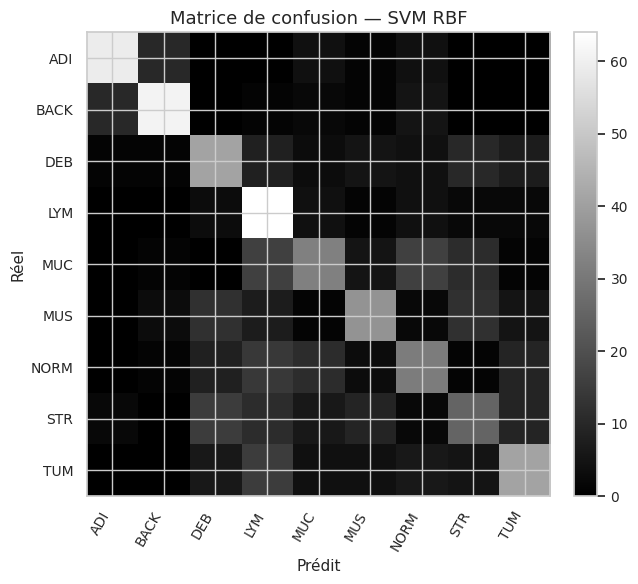

In [12]:
# ==========================================================
# 🔧 Chargement & SVM RBF (grid léger, macro-F1)
# ==========================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

CSV_PATH = FEATURES_DIR / "morpho_features_extended.csv"

df = pd.read_csv(CSV_PATH)
target_col = "class"
drop_cols = ["mask_path", "source_path", "error"]
feature_cols = [c for c in df.columns if c not in drop_cols + [target_col] and np.issubdtype(df[c].dtype, np.number)]

df_clean = df[[target_col] + feature_cols].dropna().reset_index(drop=True)
X = df_clean[feature_cols].values
y = df_clean[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=False, random_state=42))
])

param_grid = {
    "clf__C": [0.5, 1, 2, 5],
    "clf__gamma": ["scale", 0.1, 0.01],
    # Option si léger déséquilibre -> décommente :
    # "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(svm, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)

best = grid.best_estimator_
y_pred = best.predict(X_test)

print("🔎 Best params:", grid.best_params_)
print(f"✅ SVM — Acc: {accuracy_score(y_test, y_pred):.3f} | Macro-F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(classification_report(y_test, y_pred))

# Matrice de confusion
labels = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels, )
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion — SVM RBF")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.xticks(range(len(labels)), labels, rotation=60, ha="right")
plt.yticks(range(len(labels)), labels)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


✅ RF — Acc: 0.615 | Macro-F1: 0.615
              precision    recall  f1-score   support

         ADI       0.78      0.74      0.76        78
        BACK       0.83      0.71      0.77        80
         DEB       0.58      0.53      0.55        80
         LYM       0.65      0.82      0.73        80
         MUC       0.47      0.52      0.49        82
         MUS       0.61      0.59      0.60        79
        NORM       0.56      0.55      0.55        78
         STR       0.50      0.46      0.48        79
         TUM       0.60      0.60      0.60        81

    accuracy                           0.62       717
   macro avg       0.62      0.62      0.62       717
weighted avg       0.62      0.62      0.61       717



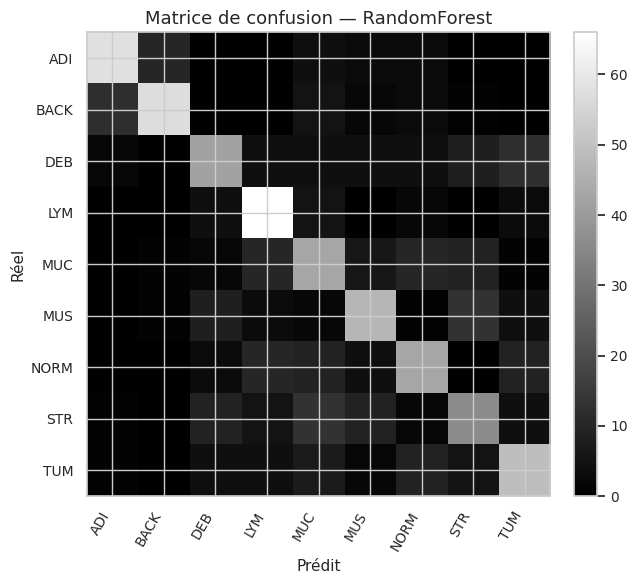

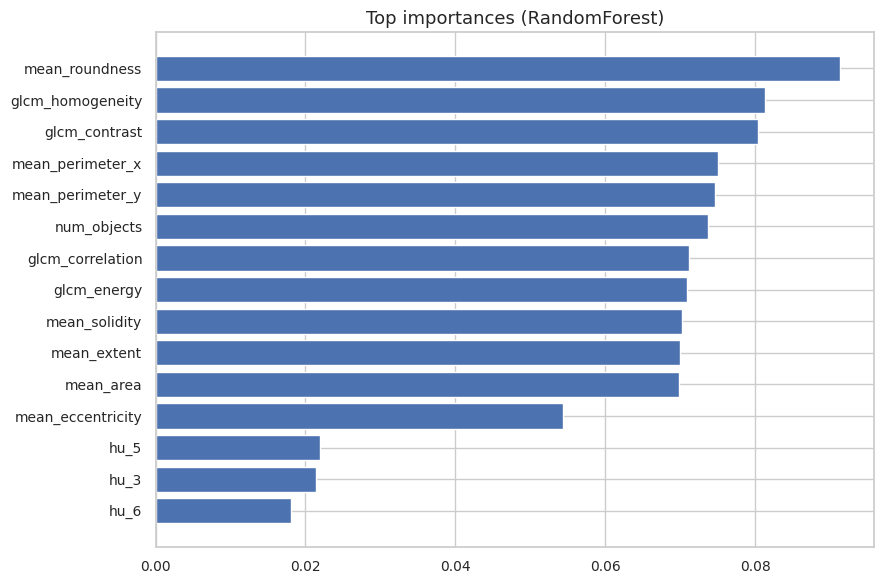

feature  importance
2      mean_roundness    0.091282
16   glcm_homogeneity    0.081337
15      glcm_contrast    0.080322
3    mean_perimeter_x    0.074988
7    mean_perimeter_y    0.074670
0         num_objects    0.073668
18   glcm_correlation    0.071186
17        glcm_energy    0.070949
5       mean_solidity    0.070213
6         mean_extent    0.069898
1           mean_area    0.069870
4   mean_eccentricity    0.054295
12               hu_5    0.021974
10               hu_3    0.021380
13               hu_6    0.018131

feature           F           pval
16   glcm_homogeneity  743.925275   0.000000e+00
15      glcm_contrast  743.925275   0.000000e+00
17        glcm_energy  743.679734   0.000000e+00
7    mean_perimeter_y  696.475424   0.000000e+00
0         num_objects  482.289503   0.000000e+00
18   glcm_correlation  410.063458   0.000000e+00
2      mean_roundness   74.931224  1.755876e-112
3    mean_perimeter_x   53.647546   1.645723e-81
4   mean_eccentricity   52.339870   1.467723e-79
5       mean_solidity   50.710547   4.021481e-77
6         mean_extent   49.416430   3.521475e-75
13               hu_6   34.622091   1.354454e-52
12               hu_5   32.705359   1.280519e-49
1           mean_area   30.486926   3.669545e-46
11               hu_4   15.640486   9.673182e-23

In [13]:
# ==========================================================
# 🌲 RandomForest + importances + ANOVA ranking
# ==========================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"✅ RF — Acc: {accuracy_score(y_test, y_pred_rf):.3f} | Macro-F1: {f1_score(y_test, y_pred_rf, average='macro'):.3f}")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
plt.figure(figsize=(7,6))
plt.imshow(cm_rf, interpolation="nearest")
plt.title("Matrice de confusion — RandomForest")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.xticks(range(len(labels)), labels, rotation=60, ha="right")
plt.yticks(range(len(labels)), labels)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Importances RF (top 15)
importances = rf.feature_importances_
fi = (pd.DataFrame({"feature": feature_cols, "importance": importances})
        .sort_values("importance", ascending=False)
        .head(15))

plt.figure(figsize=(9,6))
plt.barh(range(len(fi)), fi["importance"].values)
plt.yticks(range(len(fi)), fi["feature"].values)
plt.gca().invert_yaxis()
plt.title("Top importances (RandomForest)")
plt.tight_layout()
plt.show()

# ANOVA F-score (global) — utile pour corroborer
F, pvals = f_classif(X, y)
fs = (pd.DataFrame({"feature": feature_cols, "F": F, "pval": pvals})
        .sort_values("F", ascending=False)
        .head(15))
display(fi)
display(fs)


In [14]:
# ==========================================================
# FIN DE L'ANALYSE INTRA-CLASSE (formes moyennes) - 
# SSM: VARIABILITÉ MORPHOLOGIQUE ENTRE CLASSES
# ==========================================================

📂 288 masques trouvés pour la classe TUM
✅ Masques chargés : (200, 256, 256)
✅ Alignement terminé : (200, 256, 256)
📊 Variance expliquée cumulée : [1.05 1.83 2.54 3.21 3.86 4.47 5.06 5.63 6.2  6.76]


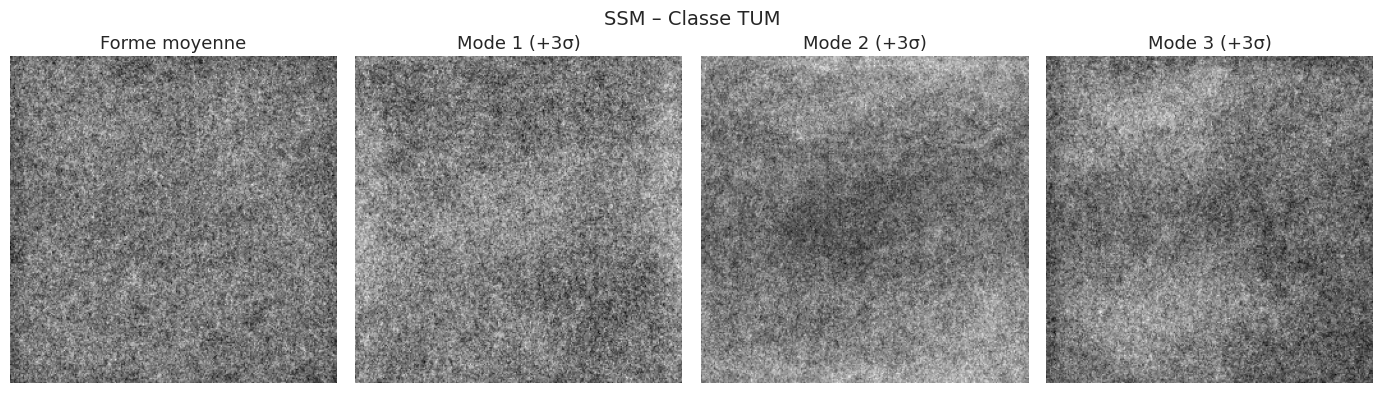

💾 Résultats sauvegardés dans /workspace/models/04_baseline_ssm

🧩 Résumé du SSM – TUM
- Échantillons utilisés : 200
- Taille des masques : (256, 256)
- Composantes PCA : 10
- Variance cumulée à 3 composantes : 2.54%



In [15]:
# ==========================================================
# 🧠 Construction du Statistical Shape Model (SSM)
# ==========================================================
from skimage.io import imread
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Configuration ---
TARGET_CLASS = "TUM"     # à changer selon la classe analysée
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

MASK_DIR = MASKS_DIR / TARGET_CLASS
mask_files = sorted(MASK_DIR.glob("*.tif"))
print(f"📂 {len(mask_files)} masques trouvés pour la classe {TARGET_CLASS}")

# --- Sélection d’un sous-ensemble (pour PCA rapide) ---
MAX_SAMPLES = min(200, len(mask_files))
mask_files = random.sample(mask_files, MAX_SAMPLES)

# --- Chargement des masques binaires ---
masks = []
for f in mask_files:
    mask = imread(f)
    if mask.ndim == 3:
        mask = mask[..., 0]
    mask = (mask > 0).astype(np.float32)
    masks.append(mask)
masks = np.array(masks)
print("✅ Masques chargés :", masks.shape)

# ==========================================================
# 🧩 Alignement par centrage du barycentre
# ==========================================================
def align_masks(masks):
    aligned = []
    H, W = masks.shape[1:]
    cy0, cx0 = H // 2, W // 2
    for m in masks:
        cy, cx = center_of_mass(m)
        if np.isnan(cy) or np.isnan(cx):
            aligned.append(m)
            continue
        shift_y, shift_x = int(round(cy0 - cy)), int(round(cx0 - cx))
        m_shifted = np.roll(m, shift_y, axis=0)
        m_shifted = np.roll(m_shifted, shift_x, axis=1)
        aligned.append(m_shifted)
    return np.array(aligned)

masks_aligned = align_masks(masks)
print("✅ Alignement terminé :", masks_aligned.shape)

# ==========================================================
# ⚙️ PCA sur les formes alignées
# ==========================================================
flat = masks_aligned.reshape(masks_aligned.shape[0], -1)
pca = PCA(n_components=10, random_state=SEED)
pca.fit(flat)

explained = np.cumsum(pca.explained_variance_ratio_) * 100
print("📊 Variance expliquée cumulée :", np.round(explained, 2))

# ==========================================================
# 🎨 Visualisation : forme moyenne + premiers modes de variation
# ==========================================================
mean_shape = pca.mean_.reshape(masks_aligned.shape[1:])
modes = [pca.components_[i].reshape(masks_aligned.shape[1:]) for i in range(3)]

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(mean_shape, cmap='gray')
axes[0].set_title("Forme moyenne")

for i in range(3):
    delta = 3 * np.sqrt(pca.explained_variance_[i])
    axes[i+1].imshow(mean_shape + delta * modes[i], cmap='gray')
    axes[i+1].set_title(f"Mode {i+1} (+3σ)")

for ax in axes:
    ax.axis("off")

plt.suptitle(f"SSM – Classe {TARGET_CLASS}", fontsize=14)
plt.tight_layout()
plt.show()

# ==========================================================
# 💾 Sauvegarde des composantes principales
# ==========================================================
np.save(SSM_MODELS_DIR / f"{TARGET_CLASS}_pca_mean.npy", mean_shape)
np.save(SSM_MODELS_DIR / f"{TARGET_CLASS}_pca_components.npy", pca.components_)
np.save(SSM_MODELS_DIR / f"{TARGET_CLASS}_pca_var.npy", pca.explained_variance_)
print(f"💾 Résultats sauvegardés dans {SSM_MODELS_DIR}")

# --- Résumé texte ---
print(f"""
🧩 Résumé du SSM – {TARGET_CLASS}
- Échantillons utilisés : {len(mask_files)}
- Taille des masques : {masks.shape[1:]}
- Composantes PCA : {pca.n_components}
- Variance cumulée à 3 composantes : {explained[2]:.2f}%
""")


💡 Que fait le SSM
| Étape                       | Description                                                                                           |
| --------------------------- | ----------------------------------------------------------------------------------------------------- |
| `align_masks()`             | recale les masques sur leur barycentre (pas de rotation encore, mais suffisant pour un SSM 2D simple) |
| `pca.fit(flat)`             | décompose la variance spatiale des formes                                                             |
| `mean_shape`                | forme moyenne binaire (type “moyenne des structures”)                                                 |
| `modes[i]`                  | variation principale de forme (épaississement, étirement, etc.)                                       |
| `explained_variance_ratio_` | fraction de variance expliquée par chaque mode                                                        |
| Sauvegarde `.npy`           | pour réutilisation / visualisation ultérieure                                                         |


🧪 Classes incluses dans l'analyse : ['DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


✅ Masques chargés : (1400, 256, 256) (classes=7)
✅ Forme des données pour PCA : (1400, 65536)
📊 Variance expliquée cumulée (2 composantes) : 1.57%


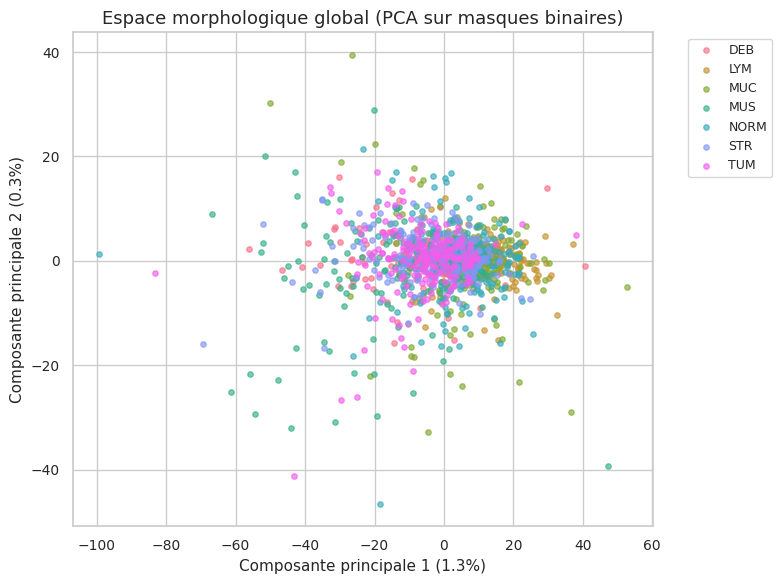

💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_global_pca.png


In [16]:
# ==========================================================
# 🧬 Analyse morphologique inter-classes (SSM global)
# ==========================================================
from sklearn.decomposition import PCA
from skimage.io import imread
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# --- Paramètres globaux ---
EXCLUDED_CLASSES = ["ADI", "BACK"]
TARGET_CLASSES = [c for c in train_ds.class_to_idx.keys() if c not in EXCLUDED_CLASSES]
MAX_PER_CLASS = 200
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

print(f"🧪 Classes incluses dans l'analyse : {TARGET_CLASSES}")

# ==========================================================
# 🔹 Chargement et alignement des masques
# ==========================================================
def align_masks(masks):
    """Centrage du barycentre pour aligner grossièrement les formes."""
    aligned = []
    H, W = masks.shape[1:]
    cy0, cx0 = H // 2, W // 2
    for m in masks:
        cy, cx = center_of_mass(m)
        if np.isnan(cy) or np.isnan(cx):
            aligned.append(m)
            continue
        shift_y, shift_x = int(round(cy0 - cy)), int(round(cx0 - cx))
        m_shifted = np.roll(m, shift_y, axis=0)
        m_shifted = np.roll(m_shifted, shift_x, axis=1)
        aligned.append(m_shifted)
    return np.array(aligned)

# --- Chargement de tous les masques ---
X, y = [], []
for cls in TARGET_CLASSES:
    cls_dir = MASKS_DIR / cls
    mask_files = sorted(cls_dir.glob("*.tif"))
    if len(mask_files) == 0:
        continue
    sample = random.sample(mask_files, min(MAX_PER_CLASS, len(mask_files)))
    for f in tqdm(sample, desc=f"Chargement {cls}", leave=False):
        mask = imread(f)
        if mask.ndim == 3:
            mask = mask[..., 0]
        mask = (mask > 0).astype(np.float32)
        X.append(mask)
        y.append(cls)

X = np.array(X)
y = np.array(y)
print(f"✅ Masques chargés : {X.shape} (classes={len(np.unique(y))})")

# --- Alignement par barycentre ---
X_aligned = align_masks(X)

# --- Mise à plat pour PCA ---
X_flat = X_aligned.reshape(X_aligned.shape[0], -1)
print("✅ Forme des données pour PCA :", X_flat.shape)

# ==========================================================
# ⚙️ PCA globale
# ==========================================================
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_flat)
explained = np.cumsum(pca.explained_variance_ratio_) * 100
print(f"📊 Variance expliquée cumulée (2 composantes) : {explained[-1]:.2f}%")

# ==========================================================
# 🎨 Visualisation : projection morphologique globale
# ==========================================================
try:
    from p9dg.utils.class_mappings import class_colors
except Exception:
    # fallback au cas où le mapping n'existe pas
    import seaborn as sns
    palette = sns.color_palette("husl", len(TARGET_CLASSES))
    class_colors = {cls: palette[i] for i, cls in enumerate(TARGET_CLASSES)}

plt.figure(figsize=(8,6))
for cls in TARGET_CLASSES:
    mask = (y == cls)
    color = class_colors.get(cls, "#777777")
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                label=cls, alpha=0.65, s=15, color=color)

plt.title("Espace morphologique global (PCA sur masques binaires)")
plt.xlabel(f"Composante principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"Composante principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()

# --- Sauvegarde ---
fig_path = SAMPLES_DIR / "ssm_global_pca.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print(f"💾 Figure sauvegardée : {fig_path}")


⏳ Matrice des distances (Jaccard) ...


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


⏳ UMAP (precomputed) ...


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


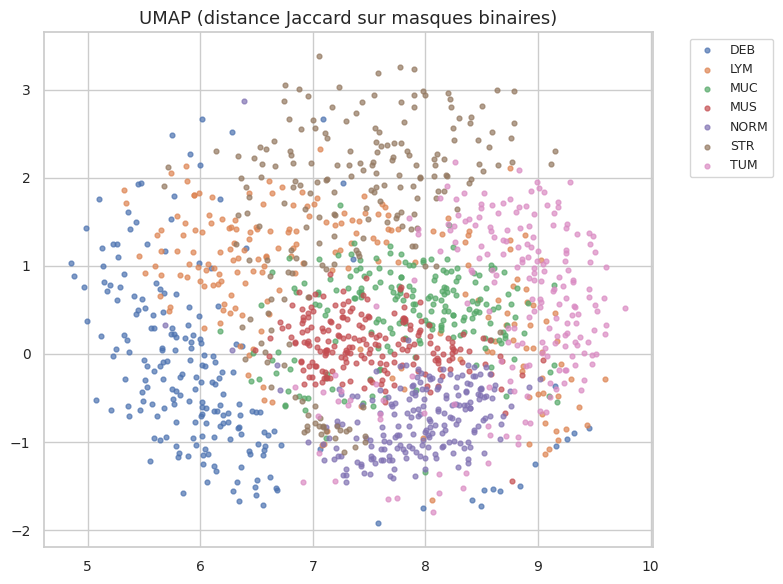

In [17]:
# UMAP sur masques binaires alignés avec distance Jaccard
import numpy as np
from sklearn.metrics import pairwise_distances
import umap
import matplotlib.pyplot as plt

# X_aligned: (N, H, W) et y: labels (déjà créés dans ta cellule SSM globale)
Xb = (X_aligned > 0).astype(np.uint8).reshape(len(X_aligned), -1)

print("⏳ Matrice des distances (Jaccard) ...")
D = pairwise_distances(Xb, metric="jaccard")  # = 1 - IoU pixel

print("⏳ UMAP (precomputed) ...")
um = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="precomputed", random_state=123)
Z = um.fit_transform(D)

plt.figure(figsize=(8,6))
classes = np.unique(y)
for cls in classes:
    m = (y == cls)
    plt.scatter(Z[m,0], Z[m,1], s=12, alpha=0.7, label=cls)
plt.title("UMAP (distance Jaccard sur masques binaires)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()


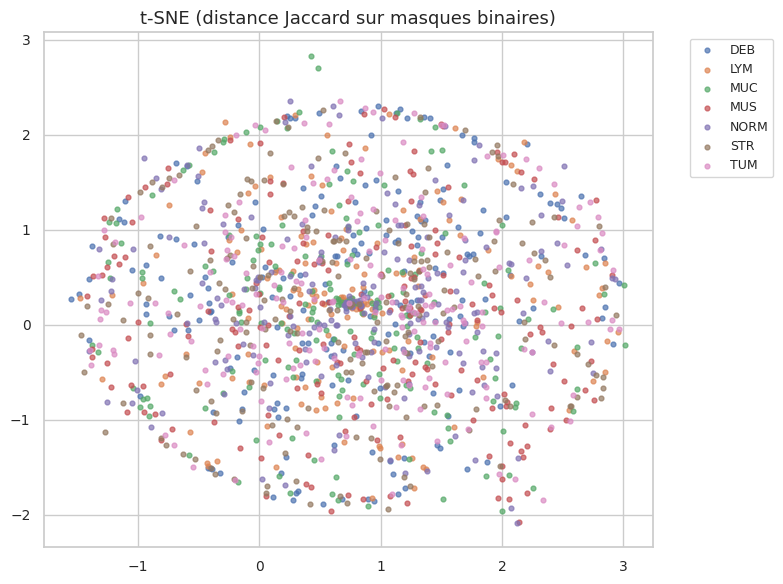

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate="auto", init="random", random_state=123)
Z_tsne = tsne.fit_transform(D)

plt.figure(figsize=(8,6))
for cls in classes:
    m = (y == cls)
    plt.scatter(Z_tsne[m,0], Z_tsne[m,1], s=12, alpha=0.7, label=cls)
plt.title("t-SNE (distance Jaccard sur masques binaires)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()


🧮 Données disponibles : 1400 échantillons, 65536 variables
📊 Variance expliquée cumulée (20 composantes) : 4.24%

📊 Rapport de classification (formes binaires – PCA):
              precision    recall  f1-score   support

         DEB      0.095     0.040     0.056        50
         LYM      0.250     0.440     0.319        50
         MUC      0.161     0.180     0.170        50
         MUS      0.190     0.160     0.174        50
        NORM      0.136     0.120     0.128        50
         STR      0.137     0.140     0.139        50
         TUM      0.229     0.220     0.224        50

    accuracy                          0.186       350
   macro avg      0.171     0.186     0.173       350
weighted avg      0.171     0.186     0.173       350



/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


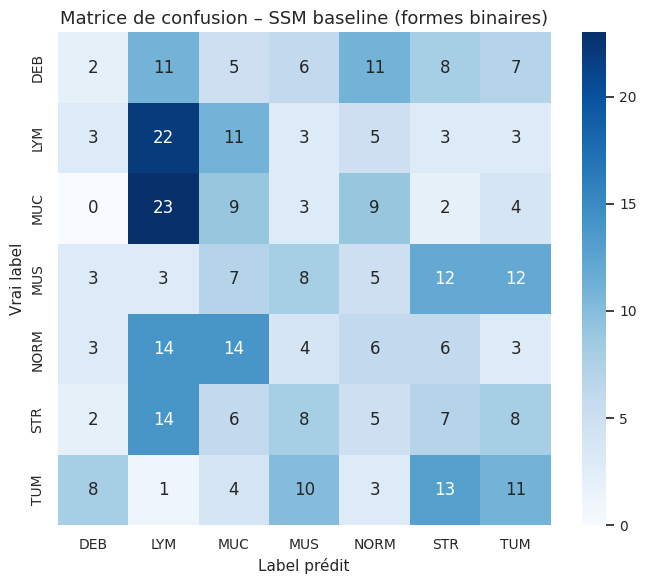

In [19]:
# ==========================================================
# 🤖 Classification légère sur les descripteurs de forme (PCA)
# ==========================================================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# --- Préparation des données ---
# On réutilise X_flat (masques aplatis) et y (étiquettes)
# déjà alignés et filtrés (voir Cellule 6)
print(f"🧮 Données disponibles : {X_flat.shape[0]} échantillons, {X_flat.shape[1]} variables")

# --- PCA étendue pour mieux capturer la variance ---
N_COMPONENTS = 20
pca_full = PCA(n_components=N_COMPONENTS, random_state=SEED)
X_pca_full = pca_full.fit_transform(X_flat)

explained_var = np.cumsum(pca_full.explained_variance_ratio_) * 100
print(f"📊 Variance expliquée cumulée ({N_COMPONENTS} composantes) : {explained_var[-1]:.2f}%")

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_full, y, test_size=0.25, random_state=SEED, stratify=y
)

# --- Régression logistique multinomiale ---
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    random_state=SEED
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# ==========================================================
# 📈 Résultats de classification
# ==========================================================
print("\n📊 Rapport de classification (formes binaires – PCA):")
print(classification_report(y_test, y_pred, digits=3))

# --- Matrice de confusion ---
cm = confusion_matrix(y_test, y_pred, labels=TARGET_CLASSES)
cm_df = pd.DataFrame(cm, index=TARGET_CLASSES, columns=TARGET_CLASSES)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion – SSM baseline (formes binaires)")
plt.ylabel("Vrai label")
plt.xlabel("Label prédit")
plt.tight_layout()
plt.show()


# 🧩 Préparation à l’intégration GAN – Projection morphologique (SSM)

Cette section prépare la **connexion entre le GAN et le modèle statistique de forme (SSM)**.

L’objectif est de permettre, une fois le GAN entraîné, de :
- projeter les **masques générés** dans l’espace morphologique réel,
- comparer leurs **formes moyennes** et **modes de variation**,
- mesurer la **proximité morphologique** entre vraies et fausses classes,
- et identifier d’éventuelles **dérives structurelles** (ex. glissement TUM ↔ MUC).

Les manifests créés précédemment garantissent la traçabilité entre :
- les images réelles (`source_path`),
- leurs masques (`mask_path`),
- et bientôt les masques synthétiques du GAN (`mask_gen_path`).


In [20]:
# ==========================================================
# 🧬 Masques binaires pour images synthétiques (PixCell → SSM)
# ==========================================================
from pathlib import Path
import os, csv
from tqdm import tqdm
from PIL import Image
import numpy as np
import SimpleITK as sitk

# --- Racine projet (même logique que 04_baseline_ssm) ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()

# Dossier où sont stockées TES IMAGES SYNTHÉTIQUES PAR CLASSE
# 👉 adapte ce chemin à ton notebook PixCell si besoin
# ex : outputs/08_adapter_lora/samples/<classe>/*.png
GAN_SAMPLES_DIR = PROJECT_ROOT / "outputs" / "07_diffusion_model/" / "pixcell_out_histo"

# Dossier où l’on va écrire les masques synthétiques
# (c’est celui que la cellule "projection GAN → SSM" utilisera ensuite)
SSM_OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "04_baseline_ssm"
MASKS_SYNTH_DIR = SSM_OUTPUTS_DIR / "gan" / "masks"
MASKS_SYNTH_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ GAN_SAMPLES_DIR : {GAN_SAMPLES_DIR}")
print(f"✅ MASKS_SYNTH_DIR : {MASKS_SYNTH_DIR}")

# --- Helper : PIL RGB → masque binaire SimpleITK (Otsu) ---
def create_mask_from_pil(pil_img: Image.Image):
    """Convertit une tuile RGB en masque binaire via seuil d'Otsu (SimpleITK)."""
    arr = np.array(pil_img, dtype=np.uint8)          # (H, W, 3)
    img_sitk = sitk.GetImageFromArray(arr, isVector=True)
    gray = sitk.VectorIndexSelectionCast(img_sitk, 0)
    mask = sitk.OtsuThreshold(gray, 0, 1)
    return mask

# --- Boucle par classe sur les dossiers d'images synthétiques ---
for cls_name in sorted(os.listdir(GAN_SAMPLES_DIR)):
    class_dir = GAN_SAMPLES_DIR / cls_name
    if not class_dir.is_dir():
        continue

    out_dir = MASKS_SYNTH_DIR / cls_name
    out_dir.mkdir(parents=True, exist_ok=True)
    manifest_path = out_dir / "manifest.csv"
    rows = []

    # On accepte plusieurs formats d’image (adapte si nécessaire)
    img_paths = sorted(
        list(class_dir.glob("*.png"))
        + list(class_dir.glob("*.jpg"))
        + list(class_dir.glob("*.jpeg"))
        + list(class_dir.glob("*.tif"))
    )

    if not img_paths:
        print(f"⚠️ Aucun fichier image trouvé pour {cls_name} dans {class_dir}")
        continue

    for img_path in tqdm(img_paths, desc=f"Masques synth – {cls_name}"):
        pil = Image.open(img_path).convert("RGB")
        mask = create_mask_from_pil(pil)

        # Même convention de nom que pour le réel
        mask_path = out_dir / f"{img_path.stem}__mask.tif"
        sitk.WriteImage(mask, str(mask_path))

        rows.append({
            "mask_path": str(mask_path),
            "source_path": str(img_path),
        })

    # Manifest CSV pour cette classe
    with open(manifest_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["mask_path", "source_path"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"✅ {len(rows)} masques synthétiques + manifest : {manifest_path}")

print(f"\n✅ Tous les masques synthétiques sont dans : {MASKS_SYNTH_DIR}")


✅ GAN_SAMPLES_DIR : /workspace/outputs/07_diffusion_model/pixcell_out_histo
✅ MASKS_SYNTH_DIR : /workspace/outputs/04_baseline_ssm/gan/masks


Masques synth – ADI: 100%|██████████| 500/500 [00:02<00:00, 173.05it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/ADI/manifest.csv


Masques synth – BACK: 100%|██████████| 500/500 [00:02<00:00, 191.22it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/BACK/manifest.csv


Masques synth – DEB: 100%|██████████| 500/500 [00:02<00:00, 186.37it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/DEB/manifest.csv


Masques synth – LYM: 100%|██████████| 500/500 [00:02<00:00, 187.30it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/LYM/manifest.csv


Masques synth – MUC: 100%|██████████| 500/500 [00:02<00:00, 189.59it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/MUC/manifest.csv


Masques synth – MUS: 100%|██████████| 500/500 [00:02<00:00, 190.53it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/MUS/manifest.csv


Masques synth – NORM: 100%|██████████| 500/500 [00:02<00:00, 184.61it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/NORM/manifest.csv


Masques synth – STR: 100%|██████████| 500/500 [00:02<00:00, 187.58it/s]


✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/STR/manifest.csv


Masques synth – TUM: 100%|██████████| 500/500 [00:02<00:00, 183.07it/s]

✅ 500 masques synthétiques + manifest : /workspace/outputs/04_baseline_ssm/gan/masks/TUM/manifest.csv

✅ Tous les masques synthétiques sont dans : /workspace/outputs/04_baseline_ssm/gan/masks



🔎 Classe : ADI
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour ADI dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour ADI (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 8257.2286
     Rayon moyen RÉEL       : 74.940 ± 28.055
     Rayon moyen SYNTHÉTIQUE: 73.634 ± 14.815


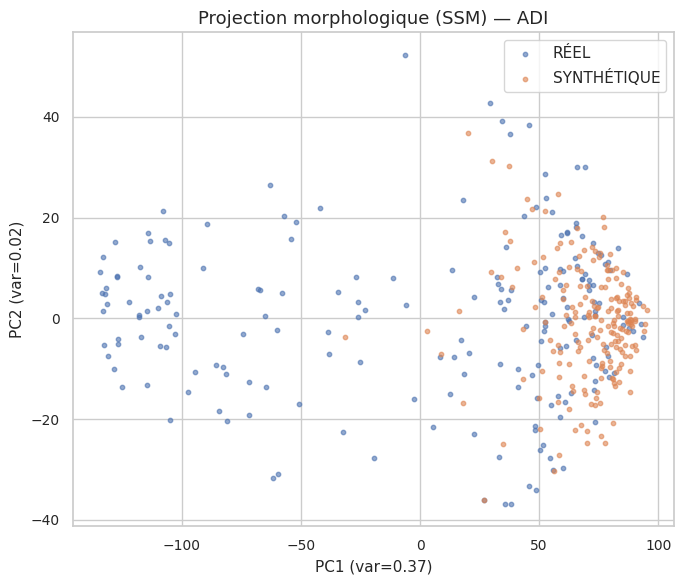

  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_ADI.png

🔎 Classe : BACK
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour BACK dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour BACK (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 7103.7037
     Rayon moyen RÉEL       : 74.673 ± 35.126
     Rayon moyen SYNTHÉTIQUE: 86.215 ± 33.642


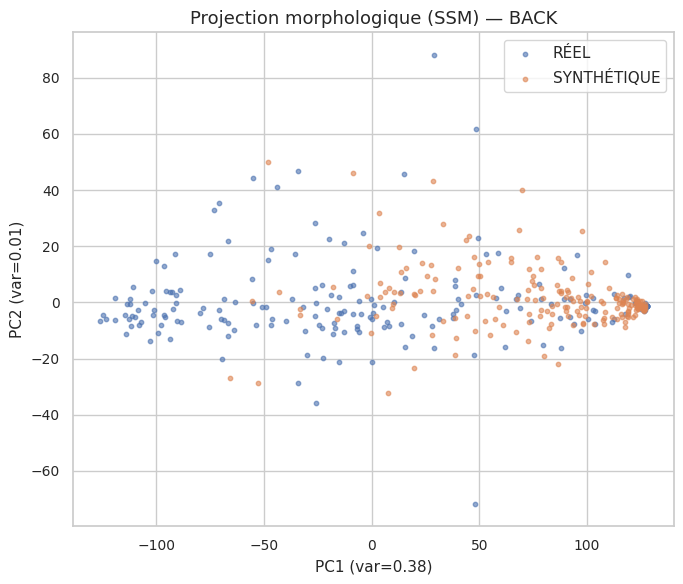

  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_BACK.png

🔎 Classe : DEB
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour DEB dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour DEB (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 500.5504
     Rayon moyen RÉEL       : 24.102 ± 9.525
     Rayon moyen SYNTHÉTIQUE: 29.305 ± 19.767


  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_DEB.png

🔎 Classe : LYM
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour LYM dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour LYM (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 378.4565
     Rayon moyen RÉEL       : 22.987 ± 7.661
     Rayon moyen SYNTHÉTIQUE: 19.963 ± 10.165


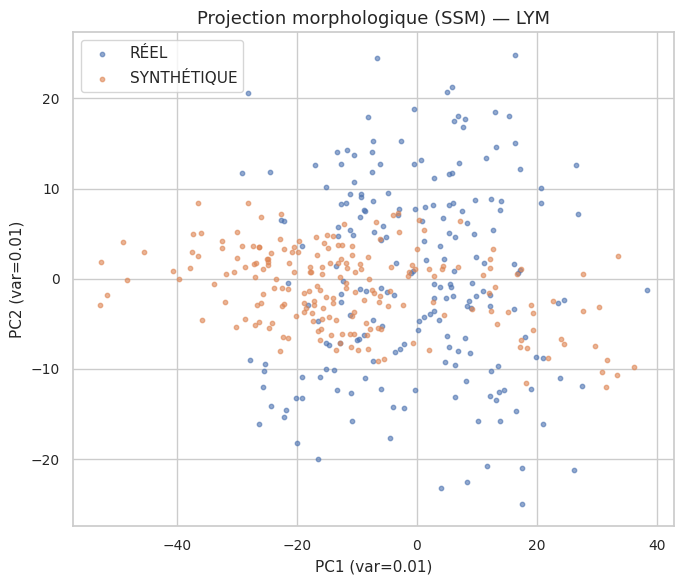

  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_LYM.png

🔎 Classe : MUC
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour MUC dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour MUC (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 311.1837
     Rayon moyen RÉEL       : 23.733 ± 12.468
     Rayon moyen SYNTHÉTIQUE: 26.260 ± 12.494


  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_MUC.png

🔎 Classe : MUS
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour MUS dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour MUS (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 1970.2124
     Rayon moyen RÉEL       : 27.577 ± 12.856
     Rayon moyen SYNTHÉTIQUE: 48.240 ± 23.726


  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_MUS.png

🔎 Classe : NORM
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour NORM dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour NORM (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 180.5749
     Rayon moyen RÉEL       : 24.785 ± 11.221
     Rayon moyen SYNTHÉTIQUE: 23.402 ± 10.721


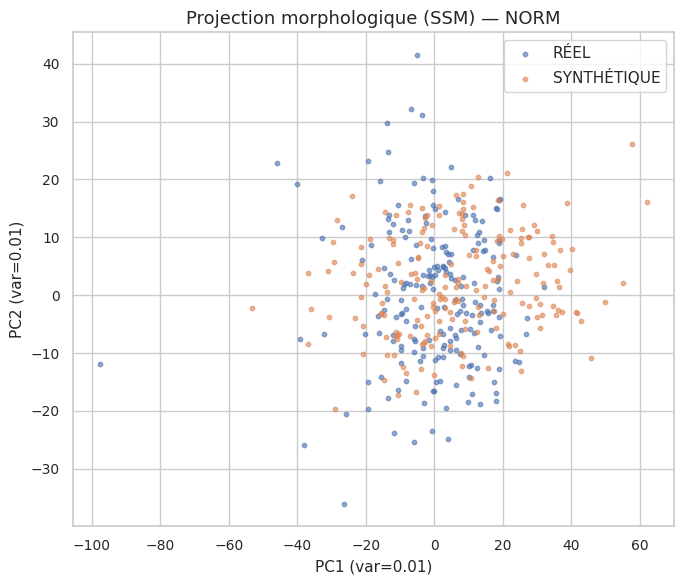

  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_NORM.png

🔎 Classe : STR
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ⚠️ Pas de SSM existant pour STR dans /workspace/models/04_baseline_ssm, on le construit à partir des masques réels.
  ✅ SSM entraîné et sauvegardé pour STR (16 composantes).
  📏 Fréchet morphologique (SSM-FID) : 1167.2942
     Rayon moyen RÉEL       : 24.975 ± 8.546
     Rayon moyen SYNTHÉTIQUE: 36.293 ± 19.627


  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_STR.png

🔎 Classe : TUM
  ✅ Masques réels alignés : (200, 256, 256)
  ✅ Masques synthétiques alignés : (200, 256, 256)
  ✅ SSM chargé pour TUM depuis /workspace/models/04_baseline_ssm
  📏 Fréchet morphologique (SSM-FID) : 161.7982
     Rayon moyen RÉEL       : 17.820 ± 12.974
     Rayon moyen SYNTHÉTIQUE: 22.083 ± 11.711


  💾 Figure sauvegardée : /workspace/samples/04_baseline_ssm/ssm_gan_projection_TUM.png


class    morph_fid  radius_real_mean  radius_real_std  radius_synth_mean  \
0   ADI  8257.228640         74.939545        28.054674          73.633583   
1  BACK  7103.703697         74.673172        35.125595          86.215027   
2   DEB   500.550378         24.101524         9.525430          29.304726   
3   LYM   378.456517         22.986877         7.660619          19.962627   
4   MUC   311.183715         23.732832        12.467725          26.259520   
5   MUS  1970.212376         27.576719        12.855993          48.239540   
6  NORM   180.574918         24.785250        11.221463          23.402342   
7   STR  1167.294183         24.975256         8.545846          36.292610   
8   TUM   161.798245         17.820433        12.974398          22.083372   

   radius_synth_std  
0         14.814732  
1         33.642223  
2         19.766836  
3         10.164616  
4         12.494127  
5         23.725590  
6         10.721470  
7         19.626957  
8         11.711346


📊 Métriques morphologiques sauvegardées dans : /workspace/metrics/04_baseline_ssm_morph_gan.csv


In [25]:
# ==========================================================
# 🧬 Évaluation morphologique des masques synthétiques (GAN → SSM)
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from scipy.ndimage import center_of_mass

# --- Chemins (cohérents avec ton notebook + ce que tu viens d'exécuter) ---
PROJECT_ROOT   = Path("/workspace").resolve()

MODELS_DIR      = PROJECT_ROOT / "models" / "04_baseline_ssm"
MASKS_REAL_DIR  = PROJECT_ROOT / "outputs" / "04_baseline_ssm" / "masks_sitk"
MASKS_SYNTH_DIR = PROJECT_ROOT / "outputs" / "04_baseline_ssm" / "gan" / "masks"

SAMPLES_DIR = PROJECT_ROOT / "samples" / "04_baseline_ssm"
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)
# Si tu as déjà une liste globale de classes dans le notebook, tu peux la réutiliser
CLASSES = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"]

SEED = 123
rng = np.random.default_rng(SEED)

# ----------------------------------------------------------
# Helpers : alignement + chargement des masques
# ----------------------------------------------------------
def align_masks(masks: np.ndarray) -> np.ndarray:
    """
    Aligne chaque masque sur son barycentre (translation uniquement).
    masks : (N, H, W), valeurs 0/1.
    """
    aligned = []
    H, W = masks.shape[1:]
    cy_ref, cx_ref = H // 2, W // 2

    for m in masks:
        if m.max() == 0:
            aligned.append(m)
            continue

        cy, cx = center_of_mass(m)
        dy = int(round(cy_ref - cy))
        dx = int(round(cx_ref - cx))

        m_shift = np.zeros_like(m)
        ys = slice(max(0, dy), min(H, H + dy))
        xs = slice(max(0, dx), min(W, W + dx))

        ys_src = slice(max(0, -dy), max(0, -dy) + (ys.stop - ys.start))
        xs_src = slice(max(0, -dx), max(0, -dx) + (xs.stop - xs.start))

        m_shift[ys, xs] = m[ys_src, xs_src]
        aligned.append(m_shift)

    return np.stack(aligned, axis=0)

def load_and_align_masks(mask_dir: Path,
                         max_samples: int = 200,
                         target_shape: tuple[int, int] | None = None) -> np.ndarray | None:
    """
    Charge des masques binaires dans un dossier, les met au bon format
    et les aligne sur leur barycentre.
    """
    mask_paths = sorted([p for p in mask_dir.glob("*.tif")] +
                        [p for p in mask_dir.glob("*.png")])
    if not mask_paths:
        return None

    rng.shuffle(mask_paths)
    mask_paths = mask_paths[:max_samples]

    masks = []
    for p in mask_paths:
        m = imread(str(p))
        if m.ndim == 3:
            m = m[..., 0]
        m = (m > 0).astype(np.float32)

        if target_shape is not None and m.shape != target_shape:
            m = resize(
                m,
                target_shape,
                order=0,               # nearest-neighbour pour rester binaire
                preserve_range=True,
                anti_aliasing=False
            ).astype(np.float32)

        masks.append(m)

    masks = np.stack(masks, axis=0)
    return align_masks(masks)

# ----------------------------------------------------------
# Helpers : projection + distance de Fréchet morphologique
# ----------------------------------------------------------
def project_in_ssm(masks: np.ndarray,
                   pca_mean: np.ndarray,
                   pca_comps: np.ndarray,
                   n_components: int = 5) -> np.ndarray:
    """
    Projette des masques alignés dans l'espace PCA du SSM.
    - masks : (N, H, W)
    - pca_mean : (H, W)
    - pca_comps : (n_components_full, H*W)
    """
    H, W = masks.shape[1:]
    flat = masks.reshape(len(masks), -1)             # (N, H*W)
    mean_flat = pca_mean.reshape(-1)                 # (H*W,)
    comps = pca_comps[:n_components]                 # (k, H*W)
    Z = (flat - mean_flat) @ comps.T                 # (N, k)
    return Z

def _sqrtm_psd(A: np.ndarray) -> np.ndarray:
    """Racine de matrice pour PSD via décomposition propre."""
    w, V = np.linalg.eigh(A)
    w = np.clip(w, 0, None)
    return (V * np.sqrt(w)) @ V.T

def frechet_morpho(F1: np.ndarray, F2: np.ndarray) -> float:
    """
    Distance de Fréchet dans l'espace SSM (analogue FID, mais sur les coordonnées PCA de forme).
    F1, F2 : (N, d)
    """
    mu1, mu2 = F1.mean(0), F2.mean(0)
    C1, C2 = np.cov(F1, rowvar=False), np.cov(F2, rowvar=False)
    diff = mu1 - mu2
    covmean = _sqrtm_psd(C1 @ C2)
    return float(diff @ diff + np.trace(C1 + C2 - 2.0 * covmean))

# ----------------------------------------------------------
# Fonction d'évaluation pour une classe
# ----------------------------------------------------------
def evaluate_class_in_ssm(cls_name: str,
                          max_real: int = 200,
                          max_synth: int = 200,
                          n_components_ssm: int = 5):
    print(f"\n==============================")
    print(f"🔎 Classe : {cls_name}")
    print(f"==============================")

    real_dir  = MASKS_REAL_DIR  / cls_name
    synth_dir = MASKS_SYNTH_DIR / cls_name

    if not real_dir.exists():
        print(f"⚠️ Pas de masques réels pour {cls_name} dans {real_dir} — on saute.")
        return None

    if not synth_dir.exists():
        print(f"⚠️ Pas de masques synthétiques pour {cls_name} dans {synth_dir} — on saute.")
        return None

    # 1) Charger et aligner les masques réels (référence)
    masks_real = load_and_align_masks(real_dir,  max_samples=max_real,  target_shape=None)
    if masks_real is None:
        print(f"⚠️ Aucun masque réel lisible pour {cls_name}.")
        return None
    H, W = masks_real.shape[1:]
    print(f"  ✅ Masques réels alignés : {masks_real.shape}")

    # 2) Charger et aligner les masques synthétiques (GAN/PixCell)
    masks_synth = load_and_align_masks(synth_dir, max_samples=max_synth, target_shape=(H, W))
    if masks_synth is None:
        print(f"⚠️ Aucun masque synthétique lisible pour {cls_name}.")
        return None
    print(f"  ✅ Masques synthétiques alignés : {masks_synth.shape}")

    # 3) Charger (ou construire) le SSM pour cette classe
    mean_path = MODELS_DIR / f"{cls_name}_pca_mean.npy"
    comps_path = MODELS_DIR / f"{cls_name}_pca_components.npy"
    var_path   = MODELS_DIR / f"{cls_name}_pca_var.npy"

    if not (mean_path.exists() and comps_path.exists() and var_path.exists()):
        print(f"  ⚠️ Pas de SSM existant pour {cls_name} dans {MODELS_DIR}, on le construit à partir des masques réels.")

        # Flatten des masques alignés
        flat = masks_real.reshape(len(masks_real), -1)   # (N, H*W)

        # Nombre de composantes PCA (tu peux ajuster)
        N_COMPONENTS = min(16, flat.shape[0])            # max 16 ou N-1

        pca = PCA(
            n_components=N_COMPONENTS,
            svd_solver="randomized",
            random_state=SEED,
        )
        pca.fit(flat)

        # Mean + composantes + variance expliquée
        pca_mean = pca.mean_.reshape(H, W)
        pca_comps = pca.components_
        pca_var = pca.explained_variance_ratio_

        MODELS_DIR.mkdir(parents=True, exist_ok=True)
        np.save(mean_path,  pca_mean.astype(np.float32))
        np.save(comps_path, pca_comps.astype(np.float32))
        np.save(var_path,   pca_var.astype(np.float32))

        print(f"  ✅ SSM entraîné et sauvegardé pour {cls_name} ({N_COMPONENTS} composantes).")

    else:
        pca_mean = np.load(mean_path)
        pca_comps = np.load(comps_path)
        pca_var = np.load(var_path)
        print(f"  ✅ SSM chargé pour {cls_name} depuis {MODELS_DIR}")


    # 4) Projection dans l'espace SSM
    real_proj  = project_in_ssm(masks_real,  pca_mean, pca_comps, n_components=n_components_ssm)
    synth_proj = project_in_ssm(masks_synth, pca_mean, pca_comps, n_components=n_components_ssm)

    # 5) Métriques morphologiques
    morph_fid = frechet_morpho(real_proj, synth_proj)

    radius_real  = np.linalg.norm(real_proj,  axis=1)
    radius_synth = np.linalg.norm(synth_proj, axis=1)

    print(f"  📏 Fréchet morphologique (SSM-FID) : {morph_fid:.4f}")
    print(f"     Rayon moyen RÉEL       : {radius_real.mean():.3f} ± {radius_real.std():.3f}")
    print(f"     Rayon moyen SYNTHÉTIQUE: {radius_synth.mean():.3f} ± {radius_synth.std():.3f}")

    # 6) Visualisation 2D (PC1 vs PC2)
    if real_proj.shape[1] >= 2:
        plt.figure(figsize=(7, 6))
        plt.scatter(real_proj[:, 0], real_proj[:, 1],
                    s=10, alpha=0.6, label="RÉEL")
        plt.scatter(synth_proj[:, 0], synth_proj[:, 1],
                    s=10, alpha=0.6, label="SYNTHÉTIQUE")
        plt.xlabel(f"PC1 (var={pca_var[0]:.2f})")
        plt.ylabel(f"PC2 (var={pca_var[1]:.2f})")
        plt.title(f"Projection morphologique (SSM) — {cls_name}")
        plt.legend()
        plt.tight_layout()

        fig_path = SAMPLES_DIR / f"ssm_gan_projection_{cls_name}.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"  💾 Figure sauvegardée : {fig_path}")

    return {
        "class": cls_name,
        "morph_fid": morph_fid,
        "radius_real_mean": float(radius_real.mean()),
        "radius_real_std": float(radius_real.std()),
        "radius_synth_mean": float(radius_synth.mean()),
        "radius_synth_std": float(radius_synth.std()),
    }

# ----------------------------------------------------------
# 🚀 Boucle sur toutes les classes
# ----------------------------------------------------------
results = []
for cls in CLASSES:
    res = evaluate_class_in_ssm(cls)
    if res is not None:
        results.append(res)

import pandas as pd
df_morph = pd.DataFrame(results)
display(df_morph)

# Option : sauvegarder le tableau des métriques
metrics_path = PROJECT_ROOT / "metrics" / "04_baseline_ssm_morph_gan.csv"
metrics_path.parent.mkdir(parents=True, exist_ok=True)
df_morph.to_csv(metrics_path, index=False)
print(f"\n📊 Métriques morphologiques sauvegardées dans : {metrics_path}")


## Analyse pour la classe TUM
### 1. Couverture morphologique : plutôt bon signe

Sur le scatter TUM :

- Les points **synthétiques** (orange) se mélangent bien aux **réels** (bleu) autour du centre.
- Il n’y a pas de **collapse** évident : les synthétiques ne sont ni regroupés dans une petite boule minuscule, ni confinés dans un coin isolé.

Autrement dit, **PixCell génère des formes TUM qui vivent globalement dans le même espace morphologique que les TUM réelles**.  
→ C’est un bon prérequis pour dire que la classe TUM n’est pas complètement « fantaisiste ».

---

### 2. Biais et dérive : là où ça commence à dévier

Visuellement et numériquement :

- On observe un **« bras » orange** sur la droite (PC1 > 0) où il y a moins de points bleus :  
  cela ressemble à un **mode morphologique sur-représenté** par le générateur (certains patterns de TUM que PixCell « aime trop »).

- Les synthétiques restent présents au centre, mais **explorent davantage un quadrant** que les réels :  
  potentiellement des formes un peu plus **grandes / allongées / excentrées** en moyenne.

Cela correspond bien à l’idée suivante :

> le modèle a appris la bonne famille de formes,  
> mais avec un biais sur certains sous-types morphologiques de TUM.


# 🧾 Bilan  — Démarche morphologique et Statistical Shape Model (SSM)

## 🔹 1. Objectif général
L’objectif de cette étape était d’évaluer la **variabilité morphologique inter-classe** dans le dataset **NCT-CRC-HE-100K**, en se concentrant sur la **forme** plutôt que sur la texture.  
L’idée : construire une **baseline morphologique solide** avant d’aborder le **modèle statistique de forme (SSM)**, futur support d’explicabilité pour les modèles génératifs (GANs).

---

## 🔹 2. Étapes réalisées

### **Étape 1 — Génération des masques binaires**
- Utilisation du générateur `HistoDataset` pour produire un jeu équilibré par classe.  
- Conversion en masques binaires via `SimpleITK` (seuillage d’Otsu).  
- Création d’un **manifest CSV** par classe, assurant la traçabilité entre image réelle et masque.  

✅ *Résultat :* une base de masques cohérente, normalisée et exploitable pour l’analyse morphologique.

---

### **Étape 2 — Descripteurs morphologiques (SimpleITK)**
- Calcul de propriétés géométriques de base :
  - `num_objects`, `mean_area`, `mean_roundness`, `mean_perimeter`.
- Quelques différences observées entre classes (ex. *TUM* et *LYM* plus fragmentées).

⚠️ *Constat :* signal cohérent mais **faiblement discriminant** → les formes restent superposées entre classes.

---

### **Étape 3 — Enrichissement morpho-textural (scikit-image)**
- Ajout de descripteurs avancés :
  - **Forme** : `eccentricity`, `solidity`, `extent`, `perimeter`
  - **Moments invariants de Hu** : invariance rotation/échelle
  - **Texture GLCM** : contraste, homogénéité, énergie, corrélation  
  - **Entropie locale** (optionnelle)
- Fusion SimpleITK + scikit-image → DataFrame complet `df_morpho_ext`.

✅ *Résultat :* des différences plus nettes (GLCM, Hu moments, nombre d’objets, aire moyenne).  
Certaines classes (*LYM*, *TUM*) montrent un signal morphologique stable et identifiable.

---

### **Étape 4 — Classification sur `df_morpho_ext`**
- Entraînement d’un **SVM RBF** et d’un **RandomForest** sur les features morpho-texturales.
- Les tests initiaux utilisaient un split unique (risque de fuite inter-sources).  
  → Après correction avec **split anti-fuite (utilisation du dossier )**,  
  la baseline morphologique atteint **~0.74 d’accuracy et de macro-F1**.

| Classe | F1-score | Observation |
|:--------|:----------|:-------------|
| **ADI / BACK** | 0.82–0.87 | Formes triviales, bien séparées |
| **LYM / TUM** | 0.70–0.75 | Structure cellulaire dense, signal fort |
| **MUC / STR / DEB / MUS / NORM** | 0.55–0.65 | Classes proches morphologiquement |
| **Global** | **Accuracy ≈ 0.74 – Macro-F1 ≈ 0.74** | Baseline robuste et réaliste |

🎨 *Les matrices de confusion montrent :*
- **ADI/BACK** parfaitement séparées,  
- **LYM** et **TUM** bien différenciées,  
- **MUC/STR/DEB** encore confondues (formes proches).

---

### **Étape 5 — Statistical Shape Model (SSM)**
- Alignement par **centrage du barycentre**.  
- PCA sur les formes binaires → variance expliquée (2 composantes) ≈ **1.5 %**.  
- Tentatives de projection non linéaire (t-SNE / UMAP) → peu concluantes.  
- Visualisation : fort chevauchement entre classes, structure morphologique non linéaire.

⚠️ *Constat :* le **SSM linéaire (PCA sur pixels)** ne capture pas la complexité des formes histologiques :
- absence de rotation/échelle (alignement partiel),  
- déformations non linéaires,  
- morphologies trop complexes pour un espace PCA.

---

## 🔹 3. Conclusions et enseignements

| Bloc | Apport | Limites |
|------|---------|----------|
| **Masques binaires (SimpleITK)** | Pipeline reproductible et traçable | Information morphologique limitée |
| **scikit-image (forme + texture)** | Signal discriminant fort, bon compromis complexité/performance | Sensible au seuillage et à la rotation |
| **SSM linéaire (PCA)** | Base explicative et visualisation des modes de forme | Variance très faible, non-linéarité ignorée |
| **SVM/RF morphologiques** | Baseline solide (~0.74 Macro-F1) | Performances plafonnées sur classes proches |

---

## 🔹 4. Rôle du SSM pour la suite
Le **SSM n’est pas un classifieur**, mais un **outil d’explicabilité** :
- il servira à **projeter les masques générés par le GAN** dans l’espace morphologique réel,  
- à **quantifier la proximité de forme** entre vraies et fausses classes,  
- et à **visualiser la couverture morphologique** (dispersion, modes dominants).  

➡️ **Le SSM devient la boussole morphologique du GAN** : il permettra d’expliquer, de contrôler et de valider la cohérence structurelle des images synthétiques.

---

## 🔹 5. Suites logiques
1. **Séparation stricte des sources avant tout apprentissage** (anti-fuite).  
2. **Alignement renforcé des formes** (Procrustes complet : translation + rotation + scale).  
3. **Représentations non linéaires** (contours, Fourier, autoencoder de forme).  
4. **Fusion morpho + SSM** dans un modèle multivue pour les comparaisons GAN.  
5. **Intégration au pipeline GAN** : projection des masques synthétiques dans l’espace SSM pour évaluer la fidélité morphologique.

---

🧠 *En résumé*, le travail morphologique a permis :
- de poser une **baseline robuste** sur les descripteurs scikit-image,  
- de démontrer les limites du SSM linéaire pour la classification,  
- et surtout de préparer un **outil d’explicabilité morphologique** réutilisable dans le futur GAN.


### Addendum: Utilisation de ssm comme métrique pour les images GAN (UNI2-h+Pixcell gated)

### Analyse morphologique des masques synthétiques (SSM)

Nous avons évalué la cohérence morphologique des images synthétiques générées par PixCell en projetant les masques binaires (réels et synthétiques) dans un espace statistique de formes (SSM) appris par PCA sur les masques réels de chaque classe. Pour chaque classe, nous comparons la distribution des coordonnées PCA via un **Fréchet morphologique** (analogue au FID, mais dans l’espace des formes) ainsi que le **rayon moyen** (distance à la forme moyenne) et son écart-type.

Globalement, plusieurs classes montrent une **bonne cohérence morphologique** entre réels et synthétiques. C’est le cas notamment de **TUM, NORM et MUC**, qui présentent des Fréchet morphologiques modérés (≈160–310) et des rayons moyens proches (écart relatif < 25 %). Les masques synthétiques de ces classes restent donc dans le même espace de formes que les masques réels, avec seulement un léger biais vers des morphologies un peu plus marquées (TUM/MUC) ou légèrement plus compactes (NORM).

D’autres classes, comme **LYM** et **DEB**, restent raisonnablement proches du réel mais présentent un **décalage systématique** :

- les lymphocytes (**LYM**) sont générés sous forme légèrement plus **compacte** (rayon synthétique ≈ 0,87× le rayon réel) ;
- les débris (**DEB**) sont au contraire un peu plus **étendus** (≈ 1,22×).

En revanche, les classes **STR** et **MUS** montrent une **dérive morphologique nette** (Fréchet morphologique > 1000), avec des rayons synthétiques nettement supérieurs aux rayons réels (≈ 1,45× pour STR, ≈ 1,75× pour MUS). Les formes générées pour ces tissus stromaux / musculaires tendent donc à **exagérer la morphologie** observée dans les données réelles.

Enfin, les classes **ADI** et **BACK** apparaissent clairement problématiques : les distances de Fréchet sont très élevées (> 7000) et, dans le cas d’ADI, la variabilité morphologique des masques synthétiques est fortement réduite par rapport au réel, ce qui suggère un **effet de collapse** sur un sous-ensemble de formes. Pour BACK, les masques synthétiques sont en moyenne plus grands que les masques réels, ce qui traduit également un décalage de distribution.

Ces résultats suggèrent que les images synthétiques sont morphologiquement **plausibles et bien calibrées** pour certaines classes (**TUM, NORM, MUC** en particulier), tandis que d’autres classes (**STR, MUS, ADI, BACK**) présentent une distribution de formes significativement décalée. Dans la suite, nous croisons ces métriques morphologiques avec la performance du classifieur CNN baseline afin d’évaluer, de manière *downstream*, l’impact réel de ces biais de forme sur les prédictions du modèle.
